In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
import scipy.interpolate
from scipy.interpolate import interp1d, CubicSpline
import scipy.optimize as opt
from jupyterthemes import jtplot
# jtplot.style(theme='monokai')


def power_utility(c,γ):
    return c**(1-γ)/(1-γ)

In [2]:
γ= 5
grid_min = 0.1
grid_max = 5
grid_size = 100
x = np.linspace(grid_min, grid_max, grid_size)
power_utility_data = power_utility(x,γ)
power_utility_cubic_approx = P.Polynomial.fit(x,power_utility_data,deg=3)
power_u_cubic_data = power_utility_cubic_approx(x)

x_nodes = [0.1,1,2,3,4,5]
x_nodes_arr = np.array(x_nodes)
y_nodes = power_utility(x_nodes_arr,γ)

power_u_spline = scipy.interpolate.CubicSpline(x_nodes,y_nodes)
power_u_spline_data = power_u_spline(x)

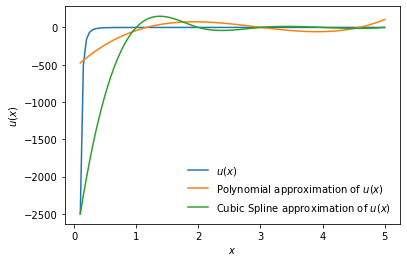

In [3]:
# Plot
fig, ax = plt.subplots()
# ax.plot(x, b_grid, 'k--')
ax.plot(x, power_utility_data, label='$u(x)$')
ax.plot(x,power_u_cubic_data, label='Polynomial approximation of $u(x)$')
ax.plot(x, power_u_spline_data, label='Cubic Spline approximation of $u(x)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$')
ax.legend(frameon=False)

plt.show()

Plot the derivative: $u(x) = x^{-\gamma}$.

In [4]:
def power_utility_deriv(c,γ):
    return c**(-γ)

power_deriv_data = power_utility_deriv(x,γ)
power_deriv_cubic_approx = power_utility_cubic_approx.deriv(1)
power_deriv_cubic_data   = power_deriv_cubic_approx(x)

spline_deriv = power_u_spline.derivative(1)
spline_deriv_data = spline_deriv(x)



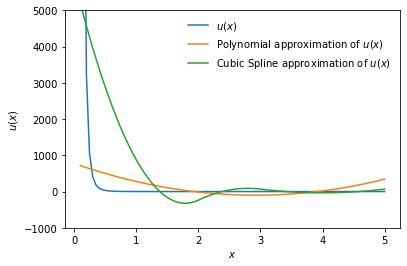

In [5]:
# Plot
fig, ax = plt.subplots()
# ax.plot(x, b_grid, 'k--')
ax.plot(x, power_deriv_data, label='$u(x)$')
ax.plot(x,power_deriv_cubic_data, label='Polynomial approximation of $u(x)$')
ax.plot(x, spline_deriv_data, label='Cubic Spline approximation of $u(x)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$')
ax.legend(frameon=False)
plt.ylim([-1000,5000])
plt.show()

We now move on to the consumption and savings problem for the entrepreneur. Recall a few details:

1) We are solving $$\nu (\omega) = \max_{b'\geq-\phi k',k'\geq 0} u(\omega - b'-k') + \beta \nu (w')$$

where $\omega = f(k) + Rb$, $u(c) = \log (c)$, and $f(k) = k^{\frac{1}{3}}$.

Also recall that we established that:

$$\omega^*=(1-\phi)\left( \frac{1}{3R} \right)^\frac{3}{2}+\left[ \beta R\nu'\left((3R)^\frac{-1}{2}-R \phi(3R)^\frac{-3}{2}\right) \right]$$

In [6]:
β = 0.8
R = 1.02
φ = 0.8

def util(c):
    return np.log(c)

def u_prime(c):
    return 1/c

def fn_prod(k):
    return k**(1/3)

def fn_marg_prod(k):
    return (1/3)*k**(-2/3)

In [7]:
def VFI_borrowing_constraint(β, R, φ):
    k_star = (3*R)**(-3/2)
    epsilon = 1e-3
    tol = 1e-09
    gap = 10
    its = 0
    maxits = 200

    omega_min = 0.1
    omega_max = 5
    omega_grid_size = 400

    omega_grid = np.linspace(omega_min, omega_max, omega_grid_size)

    VV_old    = np.log(omega_grid) # initial guess for VFI 
    VV_update = np.log(omega_grid) # value storage
    KK        = np.zeros(len(omega_grid)) # policy storage
    BB        = np.zeros(len(omega_grid))


    while its < maxits and gap > tol:
        VV_func = CubicSpline(omega_grid,VV_update) # create the spline over VV_func
        VV_prime_func = VV_func.derivative(1) # compute the derivative of temp value function
        omega_thresh = (1-φ)*(3*R)**(-3/2) + (β*R*VV_prime_func((3*R)**(-1/2)-R*φ*(3*R)**(-3/2)))**(-1) # create the constraint threshold

        i = 0 #update the state in omega in the following loop
        for w in omega_grid:

            if w > omega_thresh: # compute over unconstrained area
                k     = k_star
                b_err = lambda b: u_prime(w - b - k) - β*R*VV_prime_func(k_star**(1/3) + R*b)
                b     = opt.brentq(b_err, a = -k_star+epsilon, b = w - k_star-epsilon)
                VV_update[i] = util(w - b - k) + β*VV_func(fn_prod(k) + R*b)

            else: # compute over constrained area b' = -ϕk'
                k_err = lambda k: u_prime(w-(1-φ)*k)-β*((fn_marg_prod(k)-R*φ)/(1-φ))*VV_prime_func(fn_prod(k)-R*φ*k)
                k     = opt.brentq(k_err, epsilon, w/(1-φ)-epsilon)
                b     = -φ*k
                VV_update[i] = util(w - b - k) + β*VV_func(fn_prod(k) + R*b)

            KK[i] = k
            BB[i] = b
            i = i+1

        gap = np.linalg.norm(VV_old-VV_update)
        its = its + 1
        VV_old = np.copy(VV_update)
    return VV_update, KK, BB


In [8]:
# attempt to make code more robust - but proved unnecessary
def VFI_homotopy_deformation(β, R, φ):
    VV_exog,KK_exog,BB_exog = VFI_borrowing_constraint(β, R, 0.7)
    k_star = (3*R)**(-3/2)
    epsilon = 1e-3
    tol = 1e-09
    gap = 10
    its = 0
    maxits = 200

    omega_min = 0.1
    omega_max = 5
    omega_grid_size = 400

    omega_grid = np.linspace(omega_min, omega_max, omega_grid_size)

    VV_old    = np.log(omega_grid) # initial guess for VFI 
    VV_update = VV_exog # value storage
    KK        = np.zeros(len(omega_grid)) # policy storage
    BB        = np.zeros(len(omega_grid))


    while its < maxits and gap > tol:
        VV_func = CubicSpline(omega_grid,VV_update) # create the spline over VV_func
        VV_prime_func = VV_func.derivative(1) # compute the derivative of temp value function
        omega_thresh = (1-φ)*(3*R)**(-3/2) + (β*R*VV_prime_func((3*R)**(-1/2)-R*φ*(3*R)**(-3/2)))**(-1) # create the constraint threshold

        i = 0 #update the state in omega in the following loop
        for w in omega_grid:

            if w > omega_thresh: # compute over unconstrained area
                k     = k_star
                b_err = lambda b: u_prime(w - b - k) - β*R*VV_prime_func(k_star**(1/3) + R*b)
                b     = opt.brentq(b_err, a = -k_star+epsilon, b = w - k_star-epsilon)
                VV_update[i] = util(w - b - k) + β*VV_func(fn_prod(k) + R*b)

            else: # compute over constrained area b' = -ϕk'
                k_err = lambda k: u_prime(w-(1-φ)*k)-β*((fn_marg_prod(k)-R*φ)/(1-φ))*VV_prime_func(fn_prod(k)-R*φ*k)
                k     = opt.brentq(k_err, epsilon, w/(1-φ)-epsilon)
                b     = -φ*k
                VV_update[i] = util(w - b - k) + β*VV_func(fn_prod(k) + R*b)

            KK[i] = k
            BB[i] = b
            i = i+1

        gap = np.linalg.norm(VV_old-VV_update)
        its = its + 1
        VV_old = np.copy(VV_update)
    return VV_update, KK, BB

In [9]:
# K_path
T = 10
def k_path(KK,BB,T):
    
    T_grid = range(0,T)
    k_path = np.zeros(T)
    b_path = np.zeros(T)
    w_path = np.zeros(T+1)
    w_0 = 0.1

    k_path[0] = KK[0]
    b_path[0] = BB[0]
    w_path[1] = fn_prod(k_path[0]) +R*b_path[0]

    for i in range(1,T):
        w_ind = np.argmin(np.abs(w_path[i]-omega_grid))
        k_path[i] = KK[w_ind]
        b_path[i] = BB[w_ind]
        if i<T:
            w_path[i+1] = fn_prod(k_path[i]) + R*b_path[i]

    return k_path







In [10]:
omega_min = 0.1
omega_max = 5
omega_grid_size = 400

omega_grid = np.linspace(omega_min, omega_max, omega_grid_size)

φ = [0.9, 0.8, 0.6, 0]
KK = np.zeros( (len(omega_grid),len(φ)) )
BB = np.zeros( (len(omega_grid),len(φ)) )
VV = np.zeros( (len(omega_grid),len(φ)) )

# VV2 = VFI_borrowing_constraint(β, R, 0.8)
# VV,KK,BB = VFI_homotopy_deformation(β, R, 0)

for i in range(0,4):
    VV[:,i], KK[:,i], BB[:,i] = VFI_borrowing_constraint(β, R, φ[i])


k_path_0 = k_path(KK[:,0],BB[:,0],T)
k_path_1 = k_path(KK[:,1],BB[:,1],T)
k_path_2 = k_path(KK[:,2],BB[:,2],T)
k_path_3 = k_path(KK[:,3],BB[:,3],T)


T_grid = range(0,T)

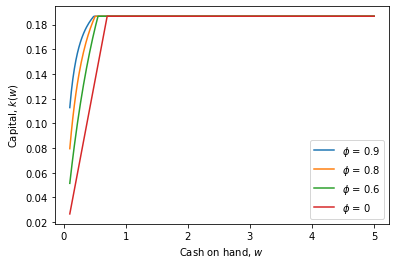

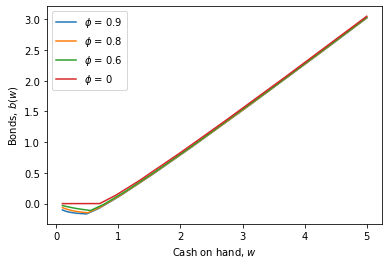

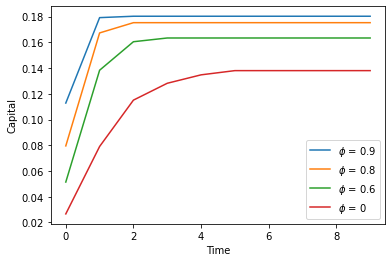

In [11]:
fig, ax = plt.subplots()
ax.plot(omega_grid, KK[:,0], label = f'$\phi$ = {φ[0]}')
ax.plot(omega_grid, KK[:,1], label = f'$\phi$ = {φ[1]}')
ax.plot(omega_grid, KK[:,2], label = f'$\phi$ = {φ[2]}')
ax.plot(omega_grid, KK[:,3], label = f'$\phi$ = {φ[3]}')
ax.set_ylabel('Capital, $k(w)$')
ax.set_xlabel('Cash on hand, $w$')
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.plot(omega_grid, BB[:,0], label = f'$\phi$ = {φ[0]}')
ax.plot(omega_grid, BB[:,1], label = f'$\phi$ = {φ[1]}')
ax.plot(omega_grid, BB[:,2], label = f'$\phi$ = {φ[2]}')
ax.plot(omega_grid, BB[:,3], label = f'$\phi$ = {φ[3]}')
ax.set_ylabel('Bonds, $b(w)$')
ax.set_xlabel('Cash on hand, $w$')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(T_grid, k_path_0, label = f'$\phi$ = {φ[0]}')
ax.plot(T_grid, k_path_1, label = f'$\phi$ = {φ[1]}')
ax.plot(T_grid, k_path_2, label = f'$\phi$ = {φ[2]}')
ax.plot(T_grid, k_path_3, label = f'$\phi$ = {φ[3]}')
ax.set_ylabel('Capital')
ax.set_xlabel('Time')
ax.legend()
plt.show()


In [12]:
import os
os.getcwd()

'C:\\Users\\flint'

In [13]:
import jupyterthemes as jt

In [14]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl
